# State of the Art VS Custom Convolution Neural Network

## Setup

## Loading the data

Doc <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#args">here</a>

In [7]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import time

In [8]:
batch_size = 64
img_width = img_height = 150
dimensions = (img_width, img_height)
input_shape = (img_width, img_height, 3)
n_classes = 6 

In [9]:
images_folder = "intel_images"
train_folder = images_folder + "/train"
test_folder = images_folder + "/test"

# Generates batches of augmented images
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True
)

# Load the images from folder
train_data = datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = datagen.flow_from_directory(
    test_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 14027 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


#### Define the classes

In [10]:
classes = []
for class_ in train_data.class_indices:
    classes.append(class_)
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

#### Plot random images

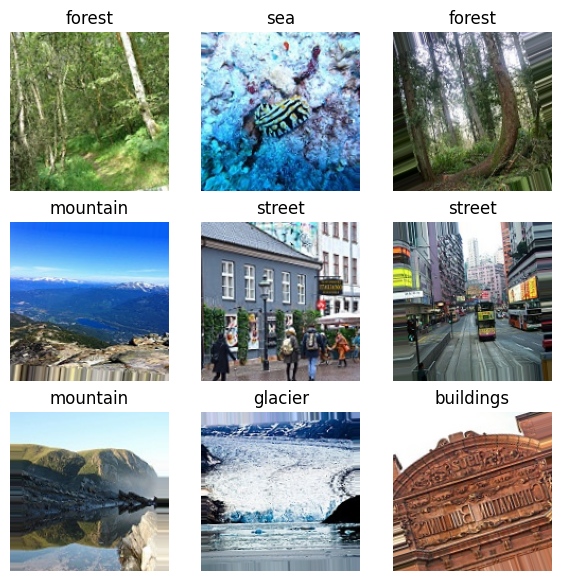

In [12]:
# Get a batch of 64 (batch_size) images and labels
images, labels = next(train_data)

# Plot the first few images and their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    label_index = np.argmax(labels[i])
    ax.set_title(classes[label_index])
    ax.axis('off')
    
plt.show()


### Separating Images from Labels

In [ ]:
def split_images_and_labels(data, full_dataset=True):
    """
    Separate the images and the labels and return them.
    full_dataset=False, it will take 10000 images 
    """
    images = []
    labels = []
    
    if full_dataset:
        dataset_size = len(data)
    else:
        dataset_size = 10000

    for i in range(dataset_size):
        batch_images, batch_labels = next(data)
        images.append(batch_images)
        labels.append(batch_labels)

    images = np.concatenate(images)
    labels = np.concatenate(labels)

    return images, labels

train_images, train_labels = split_images_and_labels(train_data)
test_images, test_labels = split_images_and_labels(test_data)

(-0.5, 149.5, 149.5, -0.5)

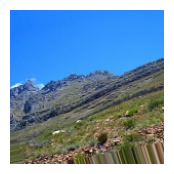

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(test_images[0])
plt.axis('off')

In [7]:
print(f"Training set: {len(train_images)} images and {len(train_labels)} labels")
print(f"Test set: {len(test_images)} images and {len(test_labels)} labels")
print(f"Train images shape: {train_images.shape} - Test images shape: {test_images.shape}")
print(f"The {train_labels.shape[1]} classes are represented as one-hot vectors of shape {train_labels.shape}")

Training set: 14027 images and 14027 labels
Test set: 3000 images and 3000 labels
Train images shape: (14027, 150, 150, 3) - Test images shape: (3000, 150, 150, 3)
The 6 classes are represented as one-hot vectors of shape (14027, 6)


## Creating a CNN

## Constants

In [14]:
img_width = img_height = 150
batch_size = 32
input_shape = (img_width, img_height, 3)
n_classes = 6

## Creating a CNN

### Architecture

In [15]:
# Define the model
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# plot_model(cnn, 'CNN.png', show_shapes=True)
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

### Training

In [16]:
import time
from keras.callbacks import EarlyStopping

In [12]:
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(14027, 150, 150, 3)
(3000, 150, 150, 3)
(14027, 6)
(3000, 6)


In [16]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

loss_stop = EarlyStopping(monitor='val_loss', patience=4, mode='min', verbose=1)
accuracy_stop = EarlyStopping(monitor='val_accuracy', patience=2)

start_time = time.time()
history = cnn.fit(train_data, 
                batch_size=batch_size,
                epochs=100, 
                validation_data=test_data,
                callbacks=[accuracy_stop, loss_stop])
end_time = time.time()

Epoch 1/100
220/220 [==============================] - 259s 1s/step - loss: 1.1266 - accuracy: 0.5653 - val_loss: 0.8980 - val_accuracy: 0.6517
Epoch 2/100
220/220 [==============================] - 237s 1s/step - loss: 0.7934 - accuracy: 0.7062 - val_loss: 0.6867 - val_accuracy: 0.7480
Epoch 3/100
220/220 [==============================] - 241s 1s/step - loss: 0.6892 - accuracy: 0.7499 - val_loss: 0.6364 - val_accuracy: 0.7737
Epoch 4/100
220/220 [==============================] - 227s 1s/step - loss: 0.6009 - accuracy: 0.7816 - val_loss: 0.5818 - val_accuracy: 0.7933
Epoch 5/100
220/220 [==============================] - 228s 1s/step - loss: 0.5658 - accuracy: 0.7943 - val_loss: 0.5599 - val_accuracy: 0.7983
Epoch 6/100
220/220 [==============================] - 226s 1s/step - loss: 0.5259 - accuracy: 0.8083 - val_loss: 0.5336 - val_accuracy: 0.8083
Epoch 7/100
220/220 [==============================] - 226s 1s/step - loss: 0.4827 - accuracy: 0.8275 - val_loss: 0.5139 - val_accuracy:

In [67]:
print("Elapsed time: {:.2f} hours" .format((end_time - start_time) / 3600))

Elapsed time: 4.55 hours


In [ ]:
def evaluate_model(history, model):

    plt.figure(figsize=(12,5))

    # Plot training and validation accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training and validation loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.suptitle('Model Performances')
    plt.show()

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f'Test loss: {test_loss}')
    print('Test accuracy: {:.2f} %' .format(test_acc * 100))

evaluate_model(history, cnn)

### Predicting new image's class

(-0.5, 149.5, 149.5, -0.5)

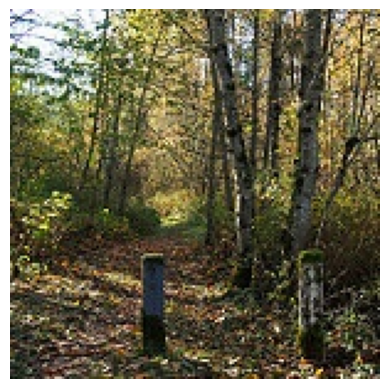

In [31]:
from tensorflow.keras.preprocessing.image import load_img

img_path = images_folder + '/pred/22.jpg'
new_image = load_img(img_path, target_size=(img_width, img_height))

plt.imshow(new_image)
plt.axis('off')

#### Preprocess the new image

In [32]:
# convert, scale and reshape the new image
new_img = np.array(new_image, dtype=np.float64)
new_img /= 255.
new_img = np.expand_dims(new_img, axis=0)
print(f'Reshape image (batch_size, w, h, channels): {new_img.shape}')

Reshape image (batch_size, w, h, channels): (1, 150, 150, 3)


#### Predict the new image label

In [34]:
y_preds = cnn.predict(new_img)
np.set_printoptions(suppress=True)
print(f'Predictions {np.round(y_preds * 100, 2)}')

1/1 [==============================] - 0s 153ms/step
Predictions [[ 0.01 99.93  0.05  0.    0.    0.01]]


#### Map predicted index to class name

I am 99.93% sure this a forest


(-0.5, 149.5, 149.5, -0.5)

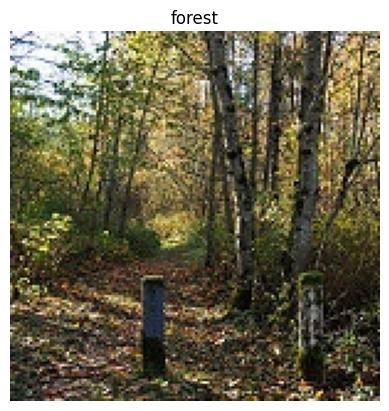

In [51]:
y_pred_index = np.argmax(y_preds)

y_pred = classes[y_pred_index]
y_proba = np.max(y_preds[0]) * 100
y_proba = round(y_proba, 2)
print(f"I am {y_proba}% sure this a {y_pred}")

plt.imshow(new_image)
plt.title(y_pred)
plt.axis('off')

## EfficientNet

In [53]:
from tensorflow.keras.applications import EfficientNetB0

# load EfficientNet with image net pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model layers to preserve weights
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the base model
enet = Sequential()
enet.add(base_model)
enet.add(GlobalAveragePooling2D())
# enet.add(Dense(128, activation=LeakyReLU(alpha=0.3)))
enet.add(Dense(n_classes, activation='softmax'))

# Compile the model
optimizer = SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
enet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
enet.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 5, 5, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# min means we want to 'minimize' the loss
loss_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)
accuracy_stop = EarlyStopping(monitor='val_accuracy', patience=2)

start_time = time.time()
enet_history = enet.fit(train_data, 
                                epochs=5,
                                validation_data=test_data,
                                callbacks=[accuracy_stop, loss_stop])
end_time = time.time()
enet_time = end_time - start_time

### Unfreeze layers 

In [58]:
for layer in base_model.layers:
    layer.trainable = True
    
optimizer = SGD(lr=0.01, momentum=0.9, decay=0.001)
enet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# min means we want to 'minimize' the loss
loss_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)
accuracy_stop = EarlyStopping(monitor='val_accuracy', patience=2)

start_time = time.time()
enet_history2 = enet.fit_generator(train_data, 
                                epochs=5,
                                validation_data=test_data,
                                callbacks=[accuracy_stop, loss_stop])
end_time = time.time()
enet_time = end_time - start_time

C:\Users\balde\AppData\Local\Temp\ipykernel_12216\483545273.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  enet_history2 = enet.fit_generator(train_data,


Epoch 1/5
220/220 [==============================] - 966s 4s/step - loss: 0.1834 - accuracy: 0.9336 - val_loss: 1.6789 - val_accuracy: 0.4660
Epoch 2/5
220/220 [==============================] - 1948s 9s/step - loss: 0.1588 - accuracy: 0.9424 - val_loss: 2.3064 - val_accuracy: 0.1470
Epoch 3/5
220/220 [==============================] - 13451s 61s/step - loss: 0.1386 - accuracy: 0.9500 - val_loss: 2.0933 - val_accuracy: 0.1750
Epoch 3: early stopping


### Evaluation

Efficient Net - Execution time: 27 minutes


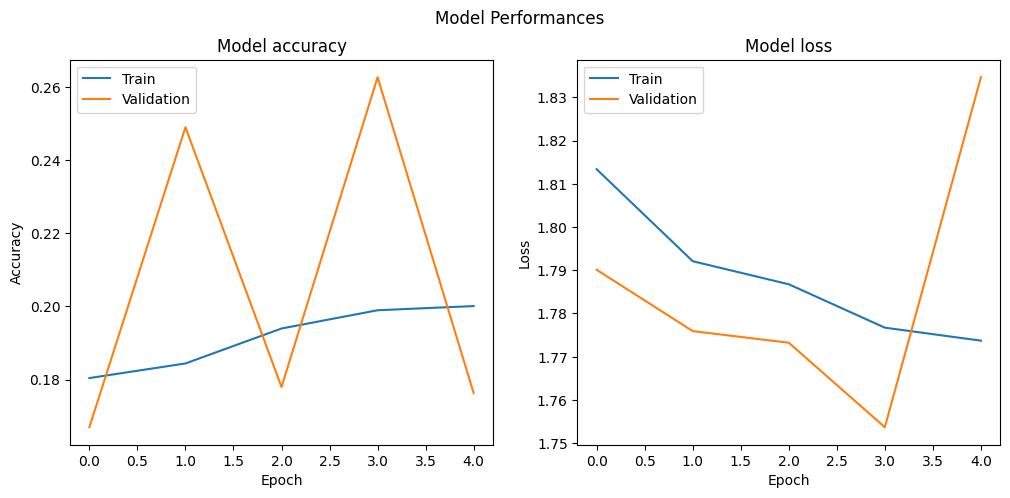

94/94 - 9s - loss: 0.6012 - accuracy: 0.7887 - 9s/epoch - 96ms/step
Test loss: 0.6011589765548706
Test accuracy: 78.87


In [ ]:
print(f"Efficient Net - Execution time: {round(enet_time / 60)} minutes")
evaluate_model(enet_history)

#### Predict the new image label

In [ ]:
# predict the new image's label
y_preds = enet.predict(new_img)
np.set_printoptions(suppress=True)
print(f'Predictions {y_preds * 100}')
# print(f'Predictions {y_preds.shape}')

1/1 [==============================] - 1s 1s/step
Predictions [[ 8.362111   7.8385262 18.61632   32.875496  24.159811   8.147738 ]]


#### Map predicted index to class name

In [ ]:
classes = train_data.class_indices
inv_classes = {v: k for k, v in class_indices.items()}

y_pred = np.argmax(y_preds)
print(f'Predicted label index: {y_pred}')

label = inv_classes[y_pred]
label_prob = round(np.max(y_preds) * 100)
print(f"I am {label_prob}% sure this a {label}")

# predicted_labels = [inv_class_indices[np.argmax(pred)] for pred in predicted_labels]
# predicted_labels

Predicted label index: 3
I am 33% sure this a mountain
